<a href="https://colab.research.google.com/github/redjin-hub/territory/blob/master/imgDetector_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/zzh8829/yolov3-tf2

Cloning into 'yolov3-tf2'...
remote: Enumerating objects: 439, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 439 (delta 10), reused 3 (delta 0), pack-reused 412
Receiving objects: 100% (439/439), 4.25 MiB | 15.20 MiB/s, done.
Resolving deltas: 100% (247/247), done.


In [2]:
%cd yolov3-tf2/
!pip install -r requirements-gpu.txt
!pip install keras==2.4.2

/content/yolov3-tf2
Obtaining file:///content/yolov3-tf2 (from -r requirements-gpu.txt (line 6))
  Attempting uninstall: yolov3-tf2
    Found existing installation: yolov3-tf2 0.1
    Can't uninstall 'yolov3-tf2'. No files were found to uninstall.
  Running setup.py develop for yolov3-tf2


In [4]:
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py --weights ./data/yolov3.weights --output ./checkpoints/yolov3.tf

--2022-02-25 00:47:41--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘data/yolov3.weights’

data/yolov3.weights 100%[===================>] 236.52M  22.5MB/s    in 11s     

2022-02-25 00:47:52 (21.3 MB/s) - ‘data/yolov3.weights’ saved [248007048/248007048]

2022-02-25 00:47:53.511749: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-02-25 00:47:55.752289: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-02-25 00:47:55.765047: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-25 00:47:55.765104: I tensorflow/stream_e

In [5]:
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import YoloV3
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs
from absl import app, logging, flags
from absl.flags import FLAGS
from keras.preprocessing import image
import matplotlib.pyplot as plt
from IPython.display import Image, display

Using TensorFlow backend.


In [20]:
flags.DEFINE_string('classes', './data/coco.names', 'classes file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolo-tiny')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf', 'weights file')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord')
flags.DEFINE_string('output', './output.jpg', 'output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

IndexError: ignored

In [24]:
yolo = YoloV3(classes=FLAGS.num_classes)
yolo.load_weights(FLAGS.weights).expect_partial()
class_names = [c.strip() for c in open(FLAGS.classes).readlines()]

In [26]:
print(len(class_names))

80


In [45]:
def detector():
  img_raw = tf.image.decode_image(open(FLAGS.image, 'rb').read(), channels=3)

  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, FLAGS.size)

  t1 = time.time()
  boxes, scores, classes, nums = yolo(img)
  t2 = time.time()
  print('time : {}'.format(t2 - t1))

  for i in range(nums[0]):
    print('{}, {}, {}'.format(class_names[int(classes[0][i])],
                              np.array(scores[0][i]),
                              np.array(boxes[0][i])))
    
  img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
  img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

  return img

In [39]:
!ls data

checkpoint  girl.png	meme.jpg      street.jpg      voc2012.names
coco.names  meme2.jpeg	meme_out.jpg  street_out.jpg  yolov3.weights


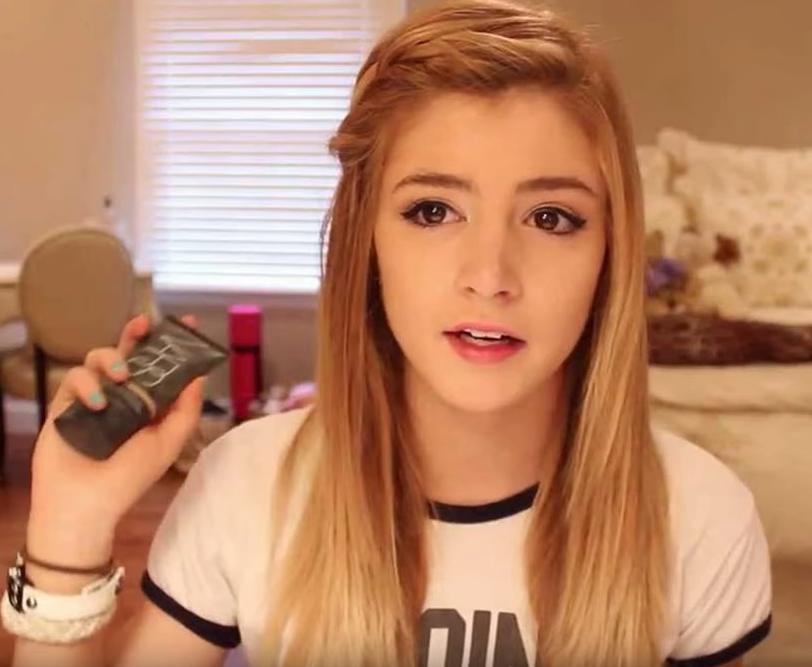

In [40]:
FLAGS.image = 'data/girl.png'
Image(filename=FLAGS.image, width=500)

time : 2.4043221473693848
person, 0.9997696280479431, [0.06754467 0.03718692 0.967988   0.96507543]
chair, 0.9255478382110596, [0.01851873 0.34200278 0.17385134 0.6278329 ]


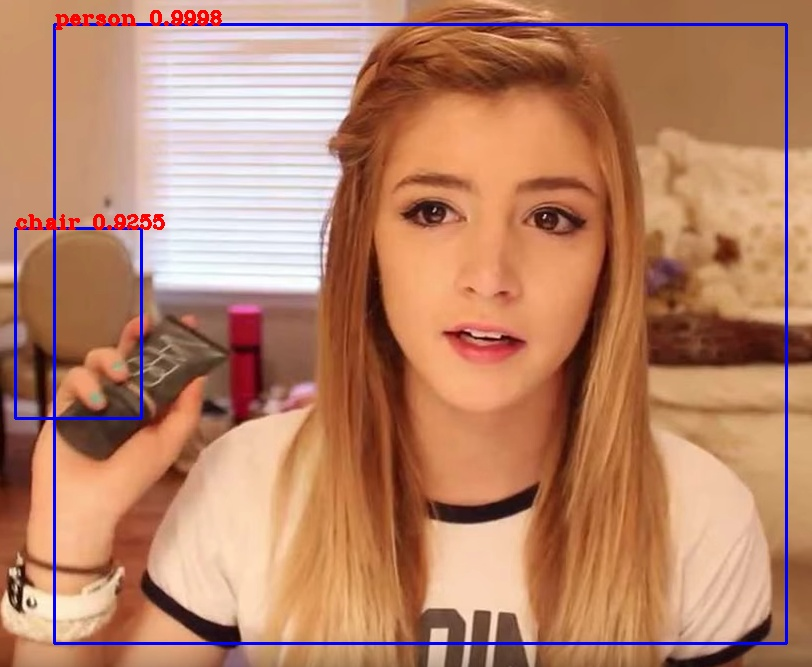

In [47]:
output = detector()
display(Image(data=bytes(cv2.imencode('.jpg', output)[1]), width=500))